In [1]:
#!pip3 install opencv-python
#!pip3 install scikit-image

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split

from scipy.ndimage import convolve, binary_fill_holes
from scipy.stats import mode

from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import rotate, hough_line, hough_line_peaks, resize
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam


from glob import glob


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

2023-07-16 04:38:07.167207: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 04:38:07.307094: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load images from csv file

path = pd.read_csv('Dataset/cards.csv')
path_df = pd.DataFrame(path)
# For column names that contain space, replace the space with an underscore
path_df.columns = [c.replace(' ', '_') for c in path_df.columns]
path_df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [3]:
path_df['suit'] = path_df['labels'].str.split().str[-1]
print(path_df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades' 'joker']


In [4]:
# Remove rows with jokers
path_df = path_df[~path_df['suit'].str.contains('joker', case=False)]
card_suits = path_df['suit'].unique()
print(card_suits)

['clubs' 'diamonds' 'hearts' 'spades']


In [5]:
path_df.head()

,class_index,filepaths,labels,card_type,data_set,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs


In [6]:
path_df = path_df.drop(columns = ['data_set'])
path_df.head()

,class_index,filepaths,labels,card_type,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,clubs


In [7]:
path_df['filepaths'] = path_df['filepaths'].apply(lambda x: 'DatasetPreProcessed/' + x)
path_df.head()

,class_index,filepaths,labels,card_type,suit
0,0,DatasetPreProcessed/train/ace of clubs/001.jpg,ace of clubs,ace,clubs
1,0,DatasetPreProcessed/train/ace of clubs/002.jpg,ace of clubs,ace,clubs
2,0,DatasetPreProcessed/train/ace of clubs/003.jpg,ace of clubs,ace,clubs
3,0,DatasetPreProcessed/train/ace of clubs/004.jpg,ace of clubs,ace,clubs
4,0,DatasetPreProcessed/train/ace of clubs/005.jpg,ace of clubs,ace,clubs


In [8]:
# Split dataframe into train and test sets
train_df, test_df = train_test_split(path_df, test_size=0.2, random_state=42)

# Split train set into train and validation sets
test_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42)

## ResNet

In [9]:
image_size = [224, 224]

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size + [3]))

print(base_model.summary())

2023-07-16 04:38:09.307622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 04:38:09.335934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 04:38:09.335982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 04:38:09.363881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 04:38:09.363936: I tensorflow/compile

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
# Don't want to train model because it is already trained.
for layer in base_model.layers:
    layer.trainable = False

In [11]:
flatten_layer = Flatten()(base_model.output)
prediction  = Dense(52, activation='softmax')(flatten_layer)
model = Model(inputs=base_model.input, outputs=prediction)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [13]:
train_data_generator = ImageDataGenerator(rescale = 1. /255,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

test_data_generator = ImageDataGenerator(rescale=1. /255)


training_set = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')

val_set = test_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')

test_set = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')



Found 6423 validated image filenames belonging to 52 classes.
Found 3212 validated image filenames belonging to 52 classes.
Found 3211 validated image filenames belonging to 52 classes.


In [14]:
result = model.fit(training_set, 
                   validation_data=val_set, 
                   epochs=300,
                   steps_per_epoch=len(training_set),
                   validation_steps=len(val_set))

Epoch 1/300


2023-07-16 04:38:16.398857: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-16 04:38:18.697432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-16 04:38:19.121857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-16 04:38:19.580655: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x560575891750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-16 04:38:19.580688: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-16 04:38:19.58516

201/201 [==============================] - ETA: 0s - loss: 8.1764 - accuracy: 0.1660

2023-07-16 04:38:49.690442: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


201/201 [==============================] - 36s 162ms/step - loss: 8.1764 - accuracy: 0.1660 - val_loss: 4.7864 - val_accuracy: 0.2849
Epoch 2/300
201/201 [==============================] - 32s 160ms/step - loss: 5.3918 - accuracy: 0.2667 - val_loss: 4.3985 - val_accuracy: 0.3577
Epoch 3/300
201/201 [==============================] - 32s 161ms/step - loss: 4.9972 - accuracy: 0.3199 - val_loss: 5.4209 - val_accuracy: 0.3861
Epoch 4/300
201/201 [==============================] - 32s 159ms/step - loss: 4.6811 - accuracy: 0.3702 - val_loss: 3.7590 - val_accuracy: 0.4359
Epoch 5/300
201/201 [==============================] - 33s 163ms/step - loss: 4.5311 - accuracy: 0.3852 - val_loss: 3.8948 - val_accuracy: 0.4785
Epoch 6/300
201/201 [==============================] - 32s 158ms/step - loss: 4.0854 - accuracy: 0.4230 - val_loss: 3.7625 - val_accuracy: 0.4648
Epoch 7/300
201/201 [==============================] - 32s 158ms/step - loss: 4.3308 - accuracy: 0.4299 - val_loss: 3.6874 - val_accurac

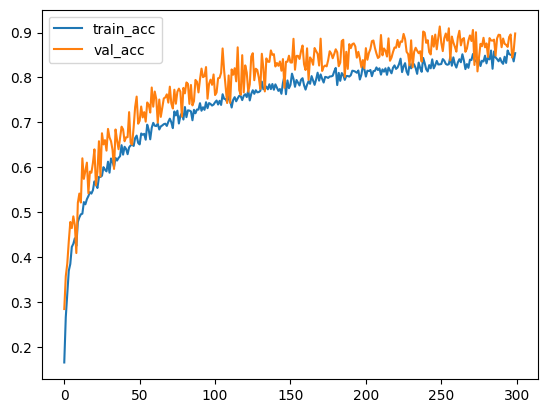

In [15]:
#Plot accuracy
plt.plot(result.history['accuracy'], label='train_acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

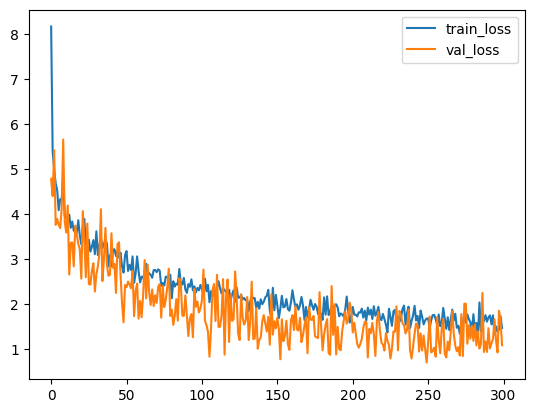

In [16]:
#Plot Loss
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_set, steps=len(test_set))

# Print the evaluation metrics
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])


  7/101 [=>............................] - ETA: 1s - loss: 1.1061 - accuracy: 0.8884

2023-07-16 07:18:46.847284: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 2s 20ms/step - loss: 1.1963 - accuracy: 0.8938
Loss: 1.1963493824005127
Accuracy: 0.8938025832176208


In [34]:
# Perform predictions on the test set
predictions = model.predict(test_set, steps=len(test_set))

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

#Print the predicted labels
print(predicted_labels[1])
print(len(predicted_labels))

  8/101 [=>............................] - ETA: 1s

2023-07-16 07:34:25.678460: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 2s 17ms/step
[33  2  9 ... 30  8 22]
2
3211


In [31]:
# Ground truth labels for the test set
true_labels = test_set.labels
print(true_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

[31, 16, 47, 5, 25, 37, 17, 27, 10, 6, 39, 38, 10, 27, 48, 16, 2, 24, 15, 16, 35, 11, 43, 46, 24, 35, 8, 24, 33, 0, 13, 10, 30, 22, 40, 13, 30, 37, 1, 7, 29, 28, 42, 49, 9, 35, 37, 7, 35, 28, 6, 46, 6, 3, 14, 9, 40, 42, 0, 41, 14, 29, 25, 29, 28, 10, 4, 5, 9, 41, 22, 30, 14, 43, 19, 32, 14, 21, 11, 33, 48, 12, 46, 3, 16, 30, 50, 40, 9, 35, 48, 28, 39, 15, 48, 10, 45, 14, 32, 5, 45, 8, 26, 30, 51, 32, 18, 18, 1, 3, 7, 40, 19, 21, 28, 7, 10, 36, 38, 34, 7, 38, 2, 38, 28, 20, 33, 18, 18, 13, 33, 31, 49, 5, 2, 40, 15, 17, 6, 11, 42, 49, 33, 3, 13, 7, 24, 21, 45, 42, 49, 23, 10, 4, 18, 44, 15, 47, 12, 8, 23, 48, 30, 2, 42, 48, 50, 36, 18, 27, 4, 43, 7, 48, 19, 12, 3, 50, 23, 44, 47, 39, 12, 33, 36, 8, 32, 44, 10, 8, 50, 11, 47, 31, 33, 29, 47, 18, 5, 28, 20, 2, 0, 35, 49, 39, 2, 47, 37, 37, 7, 41, 23, 47, 26, 1, 17, 21, 3, 51, 2, 2, 51, 49, 45, 35, 1, 21, 39, 24, 1, 12, 17, 47, 15, 16, 28, 45, 4, 30, 31, 27, 36, 48, 43, 12, 7, 19, 16, 43, 43, 41, 17, 43, 1, 38, 51, 8, 25, 34, 20, 8, 48, 19,

In [36]:
def prepareImage(PathForImage):
    image = load_img(PathForImage, target_size=(224,224))
    imgResult = img_to_array(image)
    imgResult = np.expand_dims(imgResult, axis = 0)
    imgResult = imgResult / 255.
    return imgResult

testImage = 'DatasetPreProcessed/train/ace of clubs/001.jpg'

imgForModel = prepareImage(testImage)
resultArray = model.predict(imgForModel, verbose=1)
answer = np.argmax(resultArray, axis = 1)

print(answer)



1/1 [==============================] - 1s 820ms/step
[0]
